## Suite of scripts for analyzing MSAs using Singular Value Decomposition - Homeodomain

### Version 1, updated 01-30-2023

#### Written by Gina El Nesr, Autum Koenigs, and Doug Barrick
This generates most of the plots in the paper for HD.

In [1]:
import os
import cv2
import imageio
import numpy as np
import pandas as pd
import scipy as sp

import Bio
from Bio import SeqIO

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

## Parameters & Filenames

In [2]:
# name of MSA alignment
ALIGNMENT = 'HD_aligned_gapStrip.txt'

# name of protein
PROTEIN_NAME = 'HD'

# 1 if generating and saving movies (.mp4) generated, 0 if not
MOVIES = 0

# styling
plt.style.use('svd.mplstyle.txt')

## Import Multiple Sequence Alignment

In [3]:
fasta_sequences = SeqIO.parse(open(ALIGNMENT),'fasta')

names = []
sequences = []
count = 0
for fasta in fasta_sequences:
    count += 1
    name, seq = fasta.id, str(fasta.seq)
    names.append(name)
    seq = seq.replace('X', '-')
    sequences.append(seq)

num_seqs = len(sequences)

## One-Hot Encoding Function for Sequences

In [4]:
# dictionary for amino acids to binary representation
encoder = {'A':'10000000000000000000','C':'01000000000000000000','D':'00100000000000000000',
           'E':'00010000000000000000','F':'00001000000000000000','G':'00000100000000000000',
           'H':'00000010000000000000','I':'00000001000000000000','K':'00000000100000000000',
           'L':'00000000010000000000','M':'00000000001000000000','N':'00000000000100000000',
           'P':'00000000000010000000','Q':'00000000000001000000','R':'00000000000000100000',
           'S':'00000000000000010000','T':'00000000000000001000','V':'00000000000000000100',
           'W':'00000000000000000010','Y':'00000000000000000001','-':'00000000000000000000',
           'Z':'00000000000000000000','B':'00000000000000000000'}
    

# Function ohe takes protein sequence string and returns a one-hot encoded version of that sequence
def ohe(list_residues):

    protein = "".join([encoder[R] for R in list_residues])
    
    ohe_list = [int(char) for char in protein]
    
    return ohe_list

In [5]:
ohe_list = []

for seq in sequences:
    ohe_list.append(ohe(seq)) 

F = np.array(ohe_list)
print('F-matrix generated.')

F-matrix generated.


## Perform SVD on F-matrix

In [6]:
U, S, VT = np.linalg.svd(F)
V = VT.transpose()

print('SVD has been performed.')

len_array = np.zeros(len(sequences))

SVD has been performed.


### Run this if you want the $v_i^{(1)}$ and the $\sigma_1 u_i^{(1)}$ elements to be positive.

In [7]:
if np.sum(V[:, 0]) < 0:
    U = -U
    V = -V

## Bar plots of singular values

### Bar plot of $\sigma_i$ and cumulative $\sigma_i$

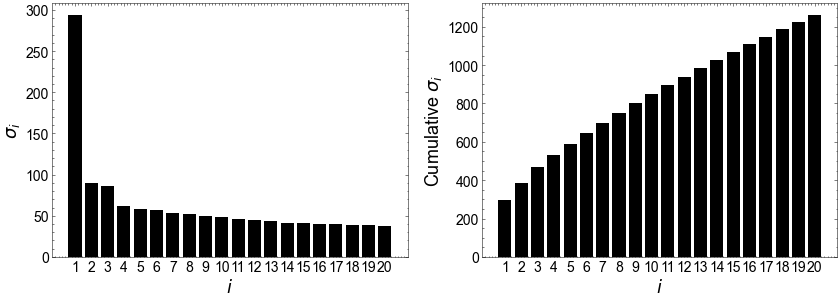

In [8]:
sum_of_sigmas = np.sum(S)
cumsum_of_sigmas = np.cumsum(S)

xticks = []
for num in range(1, 21):
    xticks.append(num)

mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}
    
fig1 = plt.figure(figsize=(12, 4.5))

plt.subplot(1, 2, 1)
plt.bar(np.arange(1, 21), height = S[:20], color='black')
plt.xticks(xticks)
plt.xlabel('$i$', fontsize = 18)
plt.ylabel('$\sigma_i$', fontsize = 18)

plt.subplot(1, 2, 2)
plt.bar(np.arange(1, 21), height = cumsum_of_sigmas[:20], color='black')
plt.xticks(xticks)
plt.xlabel('$i$', fontsize = 18)
plt.ylabel('Cumulative $\sigma_i$', fontsize = 18)

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_sigma_barchart.pdf')

### Shuffle the columns of the MSA

In [9]:
def MSA_shuffle(sequences):
    shuffled_MSA_df = pd.DataFrame()
    listed_seqs = []

    for seq in sequences:
        listed_seqs.append(list(seq))

    seq_df = pd.DataFrame(listed_seqs)
    consensus = ''

    for i in range(len(sequences[0])):
        shuffled_MSA_df[i] = np.random.permutation(seq_df[i])
    
    shuffled_MSA_list = []
    for seq_num in range(len(shuffled_MSA_df)):
        sequence = []
        for resi_num in range(len(shuffled_MSA_df.iloc[0])):
            sequence += shuffled_MSA_df[resi_num][seq_num]
        shuffled_MSA_list.append(''.join(sequence))

    return shuffled_MSA_list

shuffled_MSA_sequences = MSA_shuffle(sequences)

### OHE and SVD of shuffled sequences

In [10]:
shuffled_MSA_ohe_list = []

for seq in shuffled_MSA_sequences:
    shuffled_MSA_ohe_list.append(ohe(seq)) 

F_shuffled_MSA = np.array(shuffled_MSA_ohe_list)
print('F-matrix generated...')

U_shuffled_MSA, S_shuffled_MSA, VT_shuffled_MSA = np.linalg.svd(F_shuffled_MSA)
V_shuffled_MSA = VT_shuffled_MSA.transpose()

print('SVD has been performed.')

if np.sum(V_shuffled_MSA[:, 0]) < 0:
    U_shuffled_MSA = -U_shuffled_MSA
    V_shuffled_MSA = -V_shuffled_MSA

F-matrix generated...
SVD has been performed.


### Shuffle the F matrix and SVD.
Call it F_shuffled rather than F_shuffled_MSA

In [11]:
F_shuffled = 0*F

for column in range(len(F_shuffled[0,:])):
    F_shuffled[:, column] = np.random.permutation(F[:, column])

U_shuffled_F, S_shuffled_F, VT_shuffled_F = np.linalg.svd(F_shuffled)
V_shuffled_F = VT_shuffled_F.transpose()

print('SVD has been performed.')

SVD has been performed.


### Bar plot of $\sigma_i$ and cumulative $\sigma_i$ along with shuffled sequences and F rows

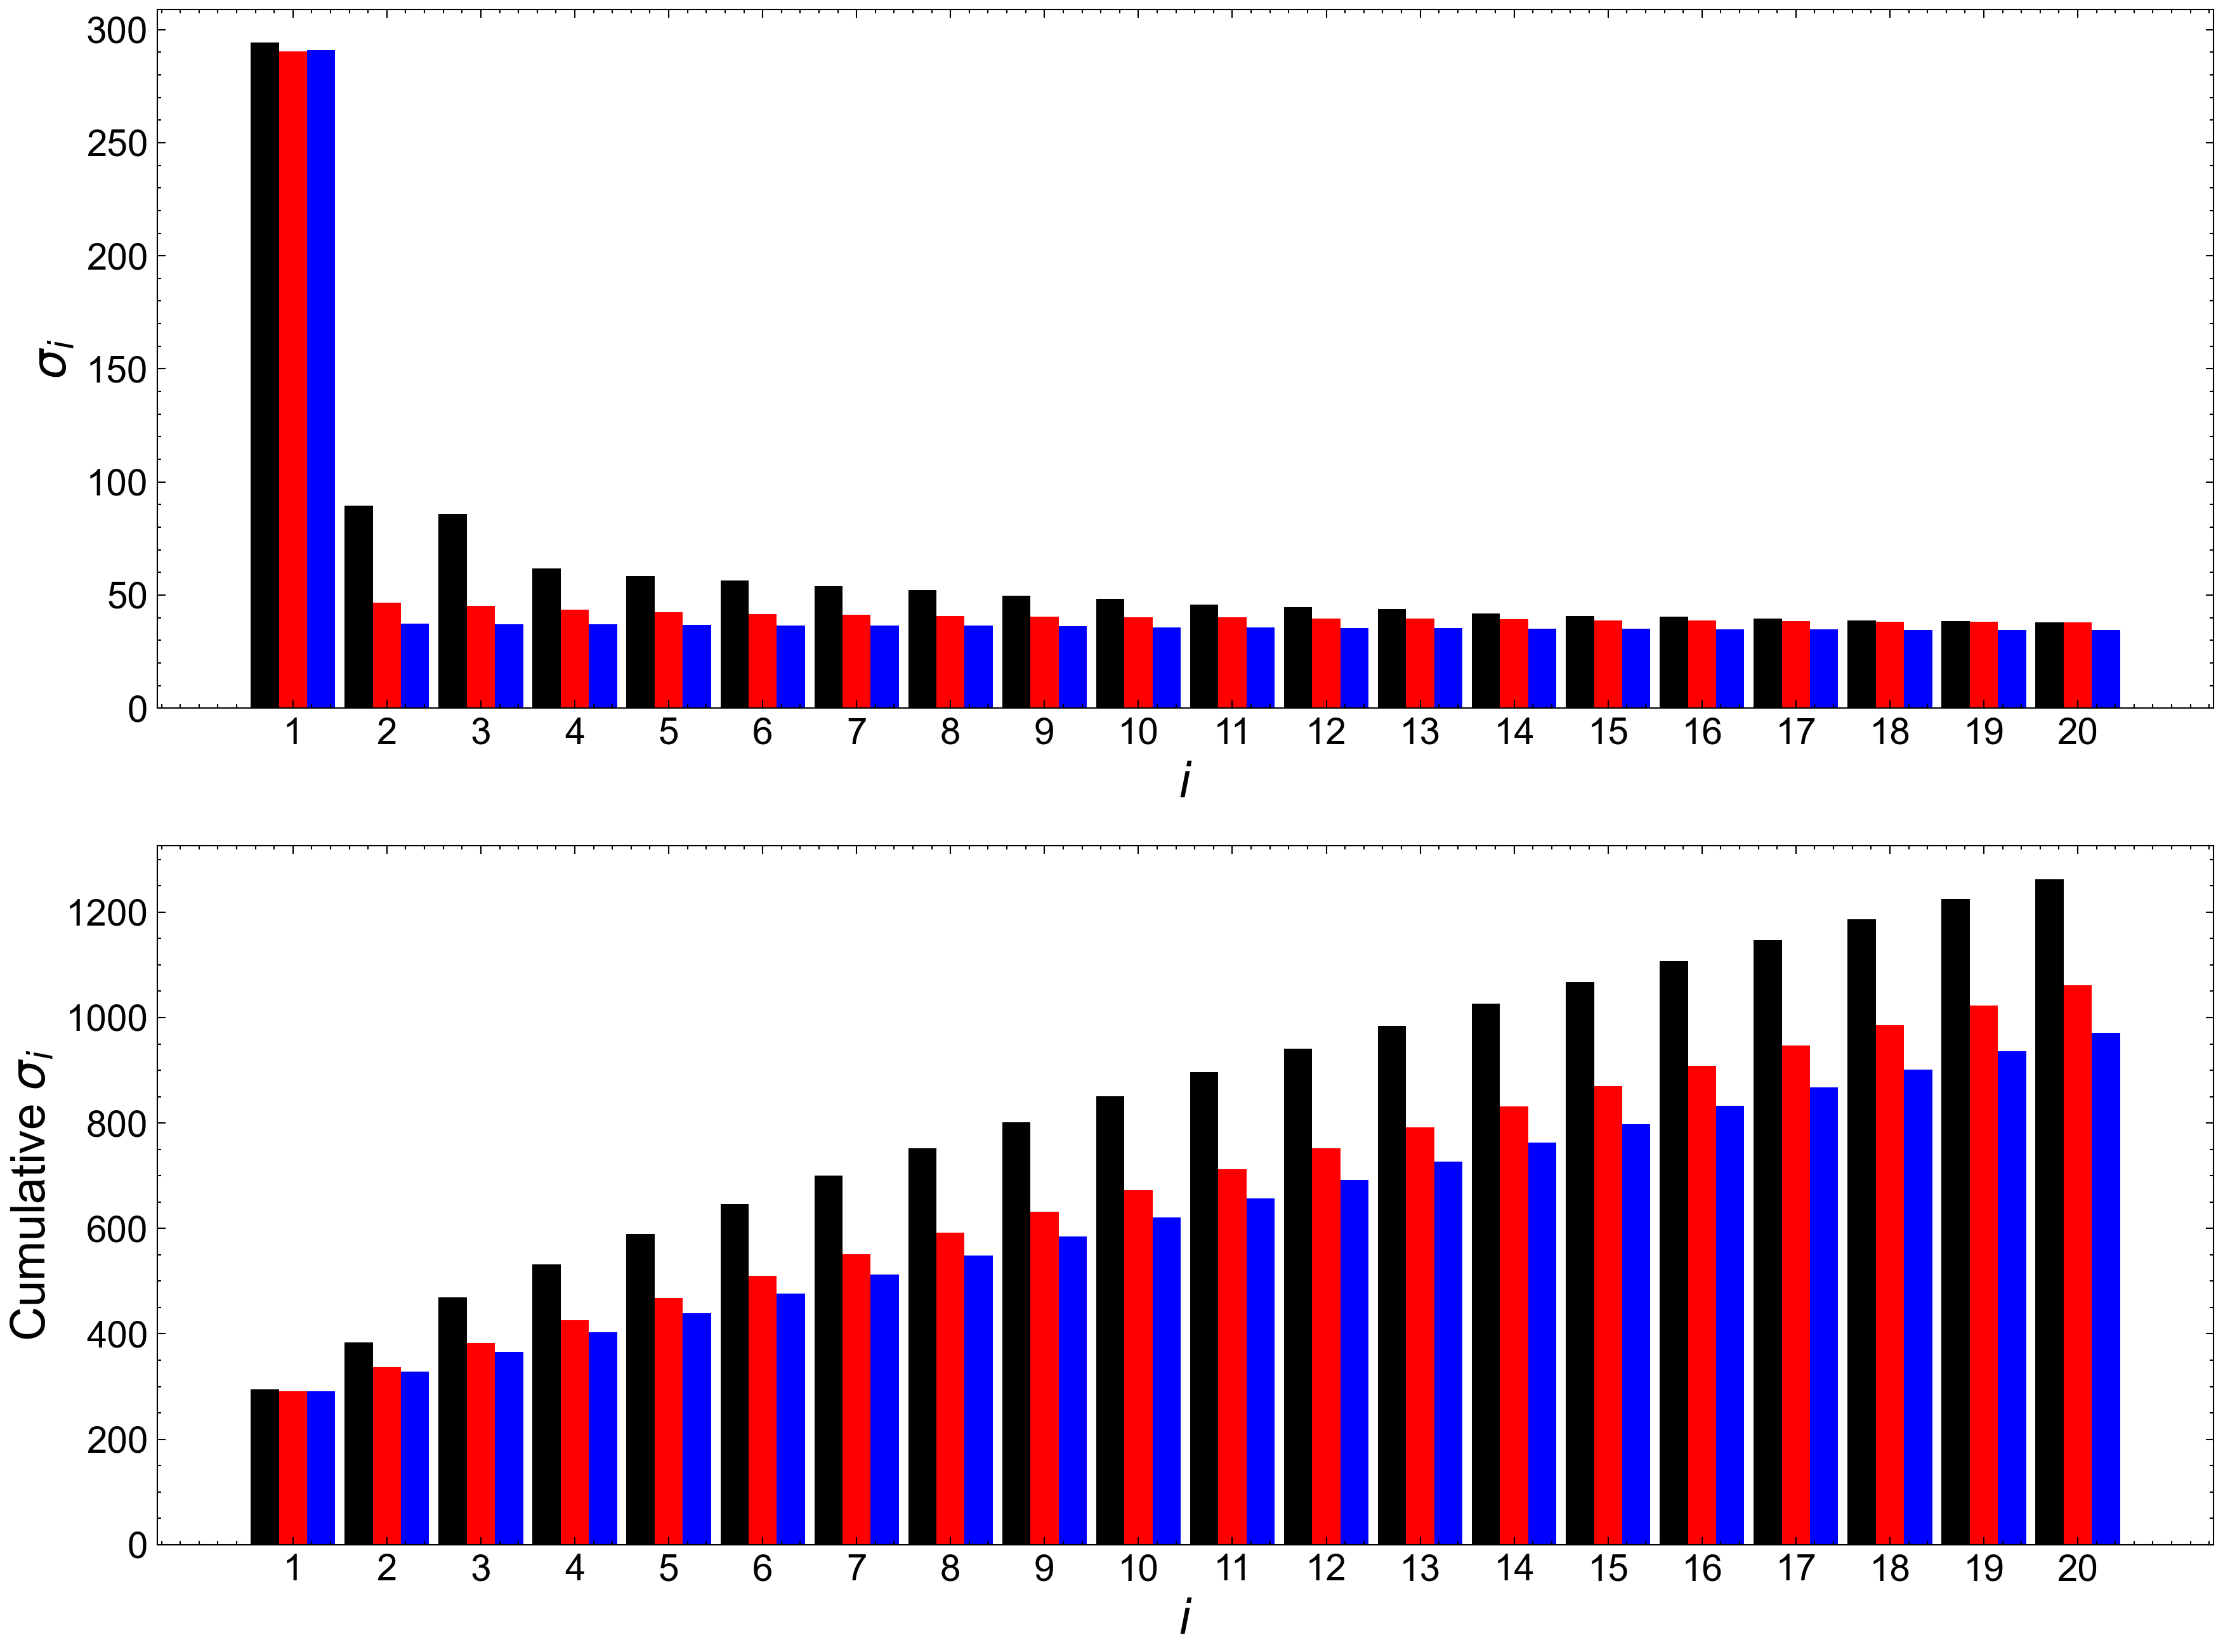

In [12]:
sum_of_sigmas = np.sum(S)
cumsum_of_sigmas = np.cumsum(S)
cumsum_of_sigmas_shuffled_MSA = np.cumsum(S_shuffled_MSA)
cumsum_of_sigmas_shuffled_F = np.cumsum(S_shuffled_F)

xticks = []
for num in range(1, 21):
    xticks.append(num)

mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}

#ind = np.arange(len(men_means))  # the x locations for the groups

w = 0.3  # the width of the bars

fig1 = plt.figure(figsize=(12, 9), dpi=300)

plt.subplot(2, 1, 1)
plt.bar(np.arange(1, 21) - w, height = S[:20], width=0.3, color='black')
plt.bar(np.arange(1, 21), height = S_shuffled_MSA[:20], width=0.3, color='red')
plt.bar(np.arange(1, 21) + w, height = S_shuffled_F[:20], width=0.3, color='blue')
plt.xticks(xticks)
plt.xlabel('$i$', fontsize = 18)
plt.ylabel('$\sigma_i$', fontsize = 18)

plt.subplot(2, 1, 2)
plt.bar(np.arange(1, 21) - w, height = cumsum_of_sigmas[:20], width=0.3, color='black')
plt.bar(np.arange(1, 21), height = cumsum_of_sigmas_shuffled_MSA[:20], width=0.3, color='red')
plt.bar(np.arange(1, 21) + w, height = cumsum_of_sigmas_shuffled_F[:20], width=0.3, color='blue')
plt.xticks(xticks)
plt.xlabel('$i$', fontsize = 18)
plt.ylabel('Cumulative $\sigma_i$', fontsize = 18)

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_sigma_shuffled_barchart.pdf')

## Plot of sequence values $\sigma_1 u_i^{(1)}$ as a function of chain length

The correlation coefficient is (0.7742727107215681, 0.0).


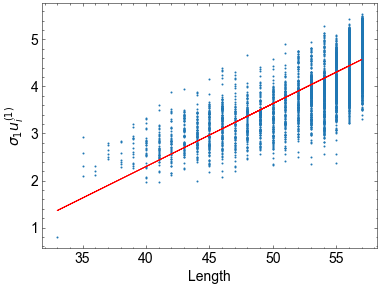

In [13]:
mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}

len_array = np.zeros(len(sequences))

i = 0
for seq in sequences:
    gaps = seq.count('-')
    seq_len = len(seq) - gaps
    len_array[i] = seq_len
    i += 1

#Linear regression
m, b = np.polyfit(len_array, S[0]*U[:, 0], 1)
pcc = sp.stats.pearsonr(len_array, S[0]*U[:, 0])
print(f'The correlation coefficient is {pcc}.')

fig1 = plt.figure(figsize=(6, 4.5))

plt.plot(len_array, S[0]*U[:, 0], 'o', markersize = 1)
plt.plot(len_array, m*len_array + b, 'r')
plt.xlabel('Length')
plt.ylabel('$\sigma_1 u_i^{{(1)}}$');
plt.savefig(f'figures/{PROTEIN_NAME}_sigmaU1_vs_length.pdf', dpi=300)

## Plotting Sequences in SVD Space

#### 2D plots of sequences along the first three singular axes

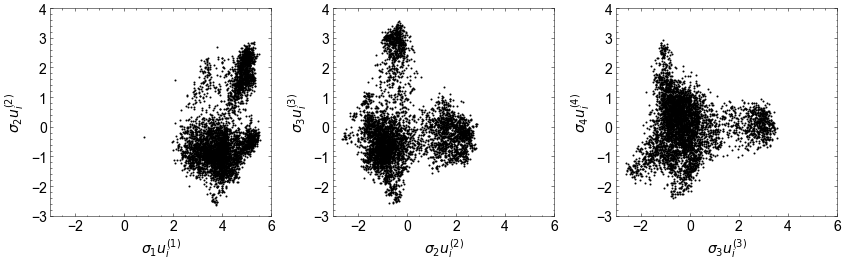

In [14]:
fig2 = plt.figure(figsize=(12,4))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.xlim(-3, 6)
    plt.ylim(-3, 4)
    plt.plot(S[i]*U[:,i], S[i+1]*U[:,i+1], 'ok',markersize=1)
    plt.xlabel(f'$\sigma_{i+1} u_i^{{({i+1})}}$')
    plt.ylabel(f'$\sigma_{i+2} u_i^{{({i+2})}}$')

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_sigmaU_2dplots.pdf')

#### 2D plots of sequences on the first 13 singular axes (12 plots)

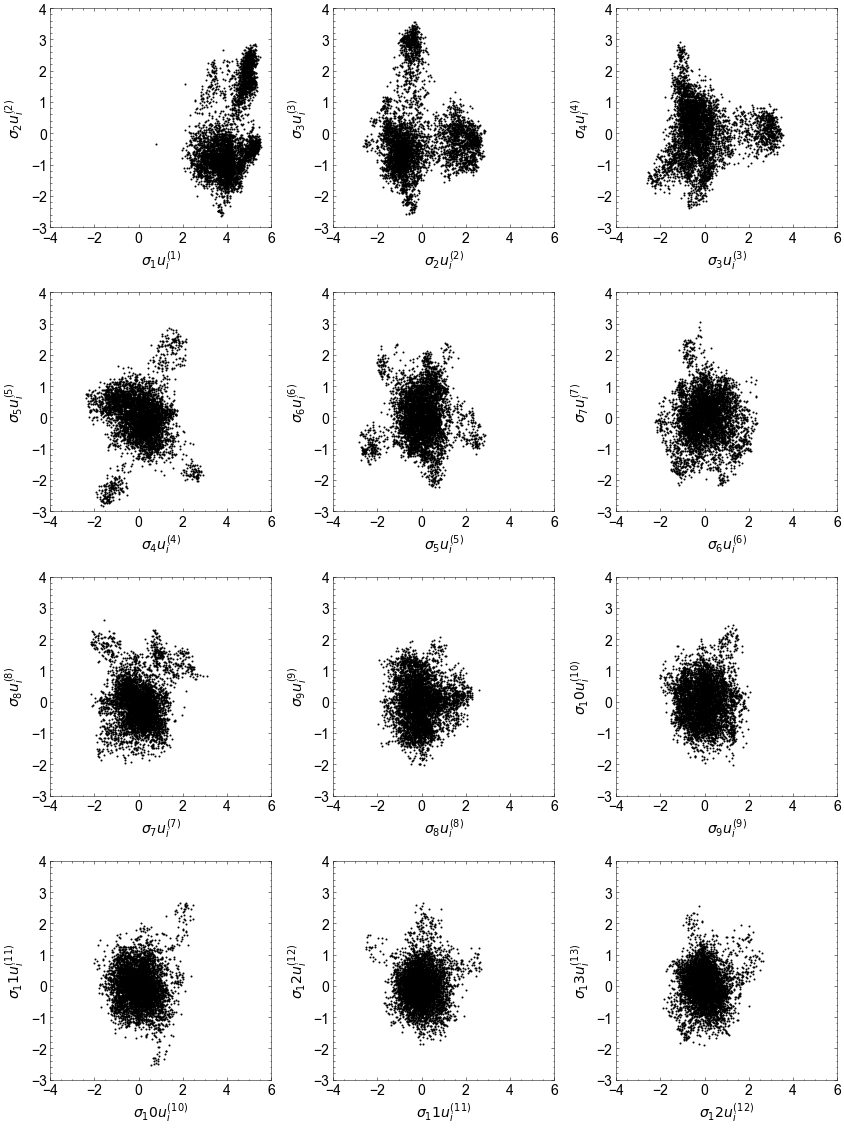

In [15]:
fig3 = plt.figure(figsize=(12,16))

for i in range(12):
    plt.subplot(4, 3, i+1)
    plt.xlim(-4, 6)
    plt.ylim(-3, 4)
    plt.plot(S[i]*U[:,i], S[i+1]*U[:,i+1], 'ok', markersize=1)
    plt.xlabel(f'$\sigma_{i+1} u_i^{{({i+1})}}$')
    plt.ylabel(f'$\sigma_{i+2} u_i^{{({i+2})}}$')
      
plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_sigmaU_12_2dplots.pdf')

#### 3D plots of sequences along the first three singular axes

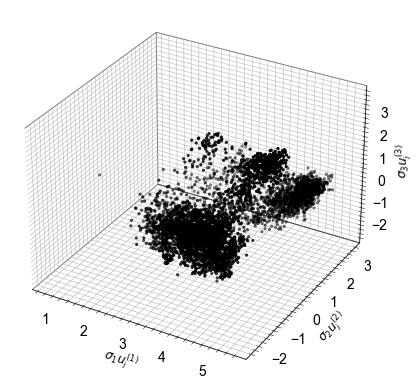

In [16]:
fig4 = plt.figure(1, figsize = (8, 7))
ax = fig4.add_subplot(projection='3d')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

ax.scatter(S[0]*U[:,0], S[1]*U[:,1], S[2]*U[:,2], c = 'black', s = 5)

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')

ax.view_init(30,300)

## K-Means Clustering

### Elbow plot to Choose Number of Clusters

The WCSS is the sum of squared distance between each point in a cluster and the cluster centroid. We use the elbow method to minimize the WCSS with as few clusters as possible. This is typically found at the "elbow" of the graph. 

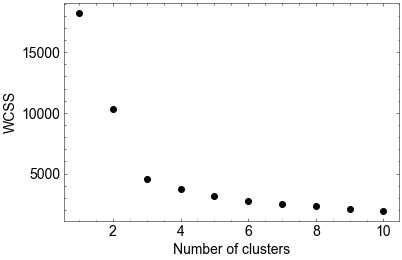

In [17]:
mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}

wcss = []

SU_df = pd.DataFrame(S*U[:,:len(S)])

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(SU_df.iloc[:, 0:3])
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(6,4))
plt.plot(range(1, 11), wcss,'o',color='black')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.savefig(f'figures/{PROTEIN_NAME}_elbowplot.pdf')

## Set the number of clusters and define colors


In [18]:
CLUSTERS = 4
cluster_ID_colormap = {0 : 'red', 1 : 'blue', 2: 'orange', 3: 'green', 4: 'black', 5: 'violet'}

## Perform K-Means clustering

In [19]:
kmeans = KMeans(n_clusters = CLUSTERS, init ='k-means++', 
                max_iter = 300, n_init = 10, random_state = 0)
cluster_ID = kmeans.fit_predict(SU_df.iloc[:, 0:3])
cluster_color = [cluster_ID_colormap[k] for k in cluster_ID]

## 2D plots of clustered sequences along the first three singular axes

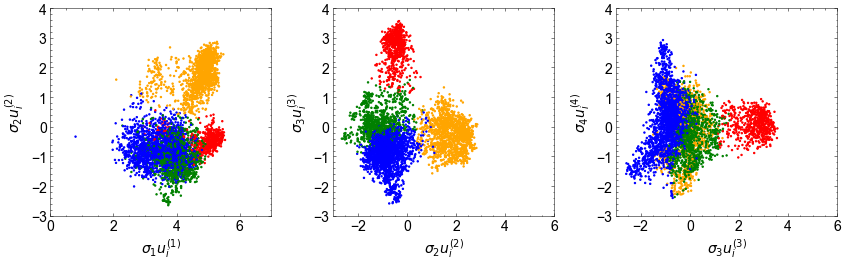

In [20]:
fig2 = plt.figure(figsize=(12,4))

for i in range(3):
    plt.subplot(1, 3, i+1)
    if i == 0:
        plt.xlim(-0, 7)
    else:
        plt.xlim(-3, 6)
    plt.ylim(-3, 4)
    plt.scatter(S[i]*U[:,i], S[i+1]*U[:,i+1], s = 2, c = cluster_color)
    plt.xlabel(f'$\sigma_{i+1} u_i^{{({i+1})}}$')
    plt.ylabel(f'$\sigma_{i+2} u_i^{{({i+2})}}$')

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_sigmaU_2dplots_cluster.pdf')

## 3D plot of sequences along the first three singular axes

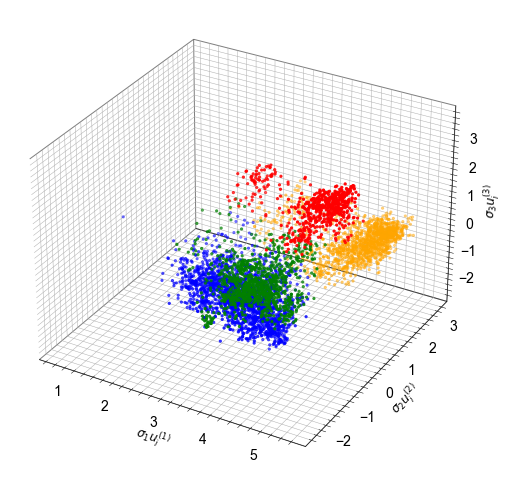

In [21]:
fig6 = plt.figure(1, figsize = (8, 7))
ax = fig6.add_subplot(projection='3d')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

ax.scatter(SU_df[0], SU_df[1], SU_df[2], c = cluster_color, s = 5)

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')

ax.view_init(30,300)

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_sigmaU_3dplot_cluster.pdf')

# Create movie of the 3D plot
if MOVIES == 1:
    imagedata = []
    for ii in range(0,360,1):
        # create temporary frame for movie
        ax.view_init(30, azim=ii)
        plt.savefig('movie%d.png' % ii)
        
        # save temporary frame for movie
        data = imageio.imread('movie{}.png'.format(ii))
        data = cv2.resize(data, (960, 960))
        imagedata.append(data)
        
        # remove temporary frame from directory
        os.remove('movie{}.png'.format(ii))

    imageio.mimwrite(f'figures/{PROTEIN_NAME}_sigmaU_3dplot_cluster.mp4', imagedata, format= '.mp4', fps = 20)

## Generating Consensus Sequences

To generate the consensus sequences, we take the most frequent residue at each position along the protein sequence. With the way we have constructed consensus, gaps have to be 50% or less at each position.

In [22]:
def create_consensus(sequences):
    listed_seqs = []

    for seq in sequences:
        listed_seqs.append(list(seq))

    seq_df = pd.DataFrame(listed_seqs)
    consensus = ''

    for i in range(len(sequences[0])):
        residues = seq_df[i].value_counts().index.tolist()
        freq = seq_df[i].value_counts()/float(seq_df.shape[0])
        if residues[0] == '-' and freq[0] < 0.5:
            consensus = consensus + residues[1]
        else:
            consensus = consensus + residues[0]

    return consensus

## Generate Consensus for the Entire MSA

In [23]:
cons_seq_all = (create_consensus(sequences))

print(cons_seq_all)

RRKRTRFTPEQLEELEKEFEKNPYPSREEREELAKELGLTERQVKVWFQNRRAKWKK


## Generate a dictionary of the sequence names (e.g., A0A1J4JHK3/1-112) in each cluster (keyed by color), used for taxonomy analysis

In [24]:
colors = list(cluster_ID_colormap.values())

names_in_color_dict = {c: [] for c in colors[:cluster_ID.max()+1]}

for j in range(len(cluster_ID)):
    label = cluster_ID_colormap[cluster_ID[j]]
    names_in_color_dict[label].append(names[j])

df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in names_in_color_dict.items()]))
df.to_csv(f'{PROTEIN_NAME}_{CLUSTERS}_clusters.csv') 

## Create consensus sequences for individual clusters

In [25]:
cons_seqs_clusters = []

for c in range(CLUSTERS):
    cluster_names = names_in_color_dict[colors[c]]

    seqs_in_cluster = []
    for name in cluster_names:
        id_seq = names.index(name)
        seqs_in_cluster.append(sequences[id_seq])
    
    cons_seqs_clusters.append(create_consensus(seqs_in_cluster))
    
    print(colors[c] + ': ' + cons_seqs_clusters[c] +'\n')
    ofile = open(f'{PROTEIN_NAME}_clusters/{PROTEIN_NAME}_{CLUSTERS}_{colors[c]}.txt', "w")

    for i in range(len(cluster_names)):
        ofile.write(">" + cluster_names[i] + "\n" + seqs_in_cluster[i] + "\n")
    
    ofile.close()

red: RRNRTTFTSEQLEELEKAFEKTHYPDVFTREELALKTNLPEARVQVWFQNRRAKWRK

blue: --KRTRFTPEQLEILEEVFEENPYPSSEEKEELAEELGLTPRQVQVWFQNRRAREK-

orange: RRPRTAFTSEQLLELEKEFERQKYLSRPERAELAASLGLTETQVKIWFQNRRMKWKR

green: KRKRTRFTPEQLEILEAAFEKNPYPDREEREELAEELGLSERVVQVWFQNRRAKERK



## Projecting consensus sequences into SVD space

To project the conesnsus sequences into SVD space, we take the product between the one-hot encoding of the consensus sequences and the residue eigenvector matrix V.

In [26]:
cons_all_ohe = ohe(cons_seq_all)
cons_all_sigmau_coords = np.matmul(cons_all_ohe, V)

cons_clusters_sigmau_coords = np.zeros([CLUSTERS, len(V)])

for i in range(len(cons_seqs_clusters)):
    cons_ohe = ohe(cons_seqs_clusters[i])
    cons_clusters_sigmau_coords[i, :] = np.matmul(cons_ohe, V)

## Compare $\sigma_1 u_1^{(1)}$ values to matches to consensus.  Easiest to do with binary encodings.

In [27]:
idents_to_cons = np.zeros(len(sequences))

i = 0
while i < len(F):
    idents_to_cons[i] = np.dot(F[i,:], cons_all_ohe)
    i += 1

The correlation coefficient is (0.9423361426157485, 0.0).


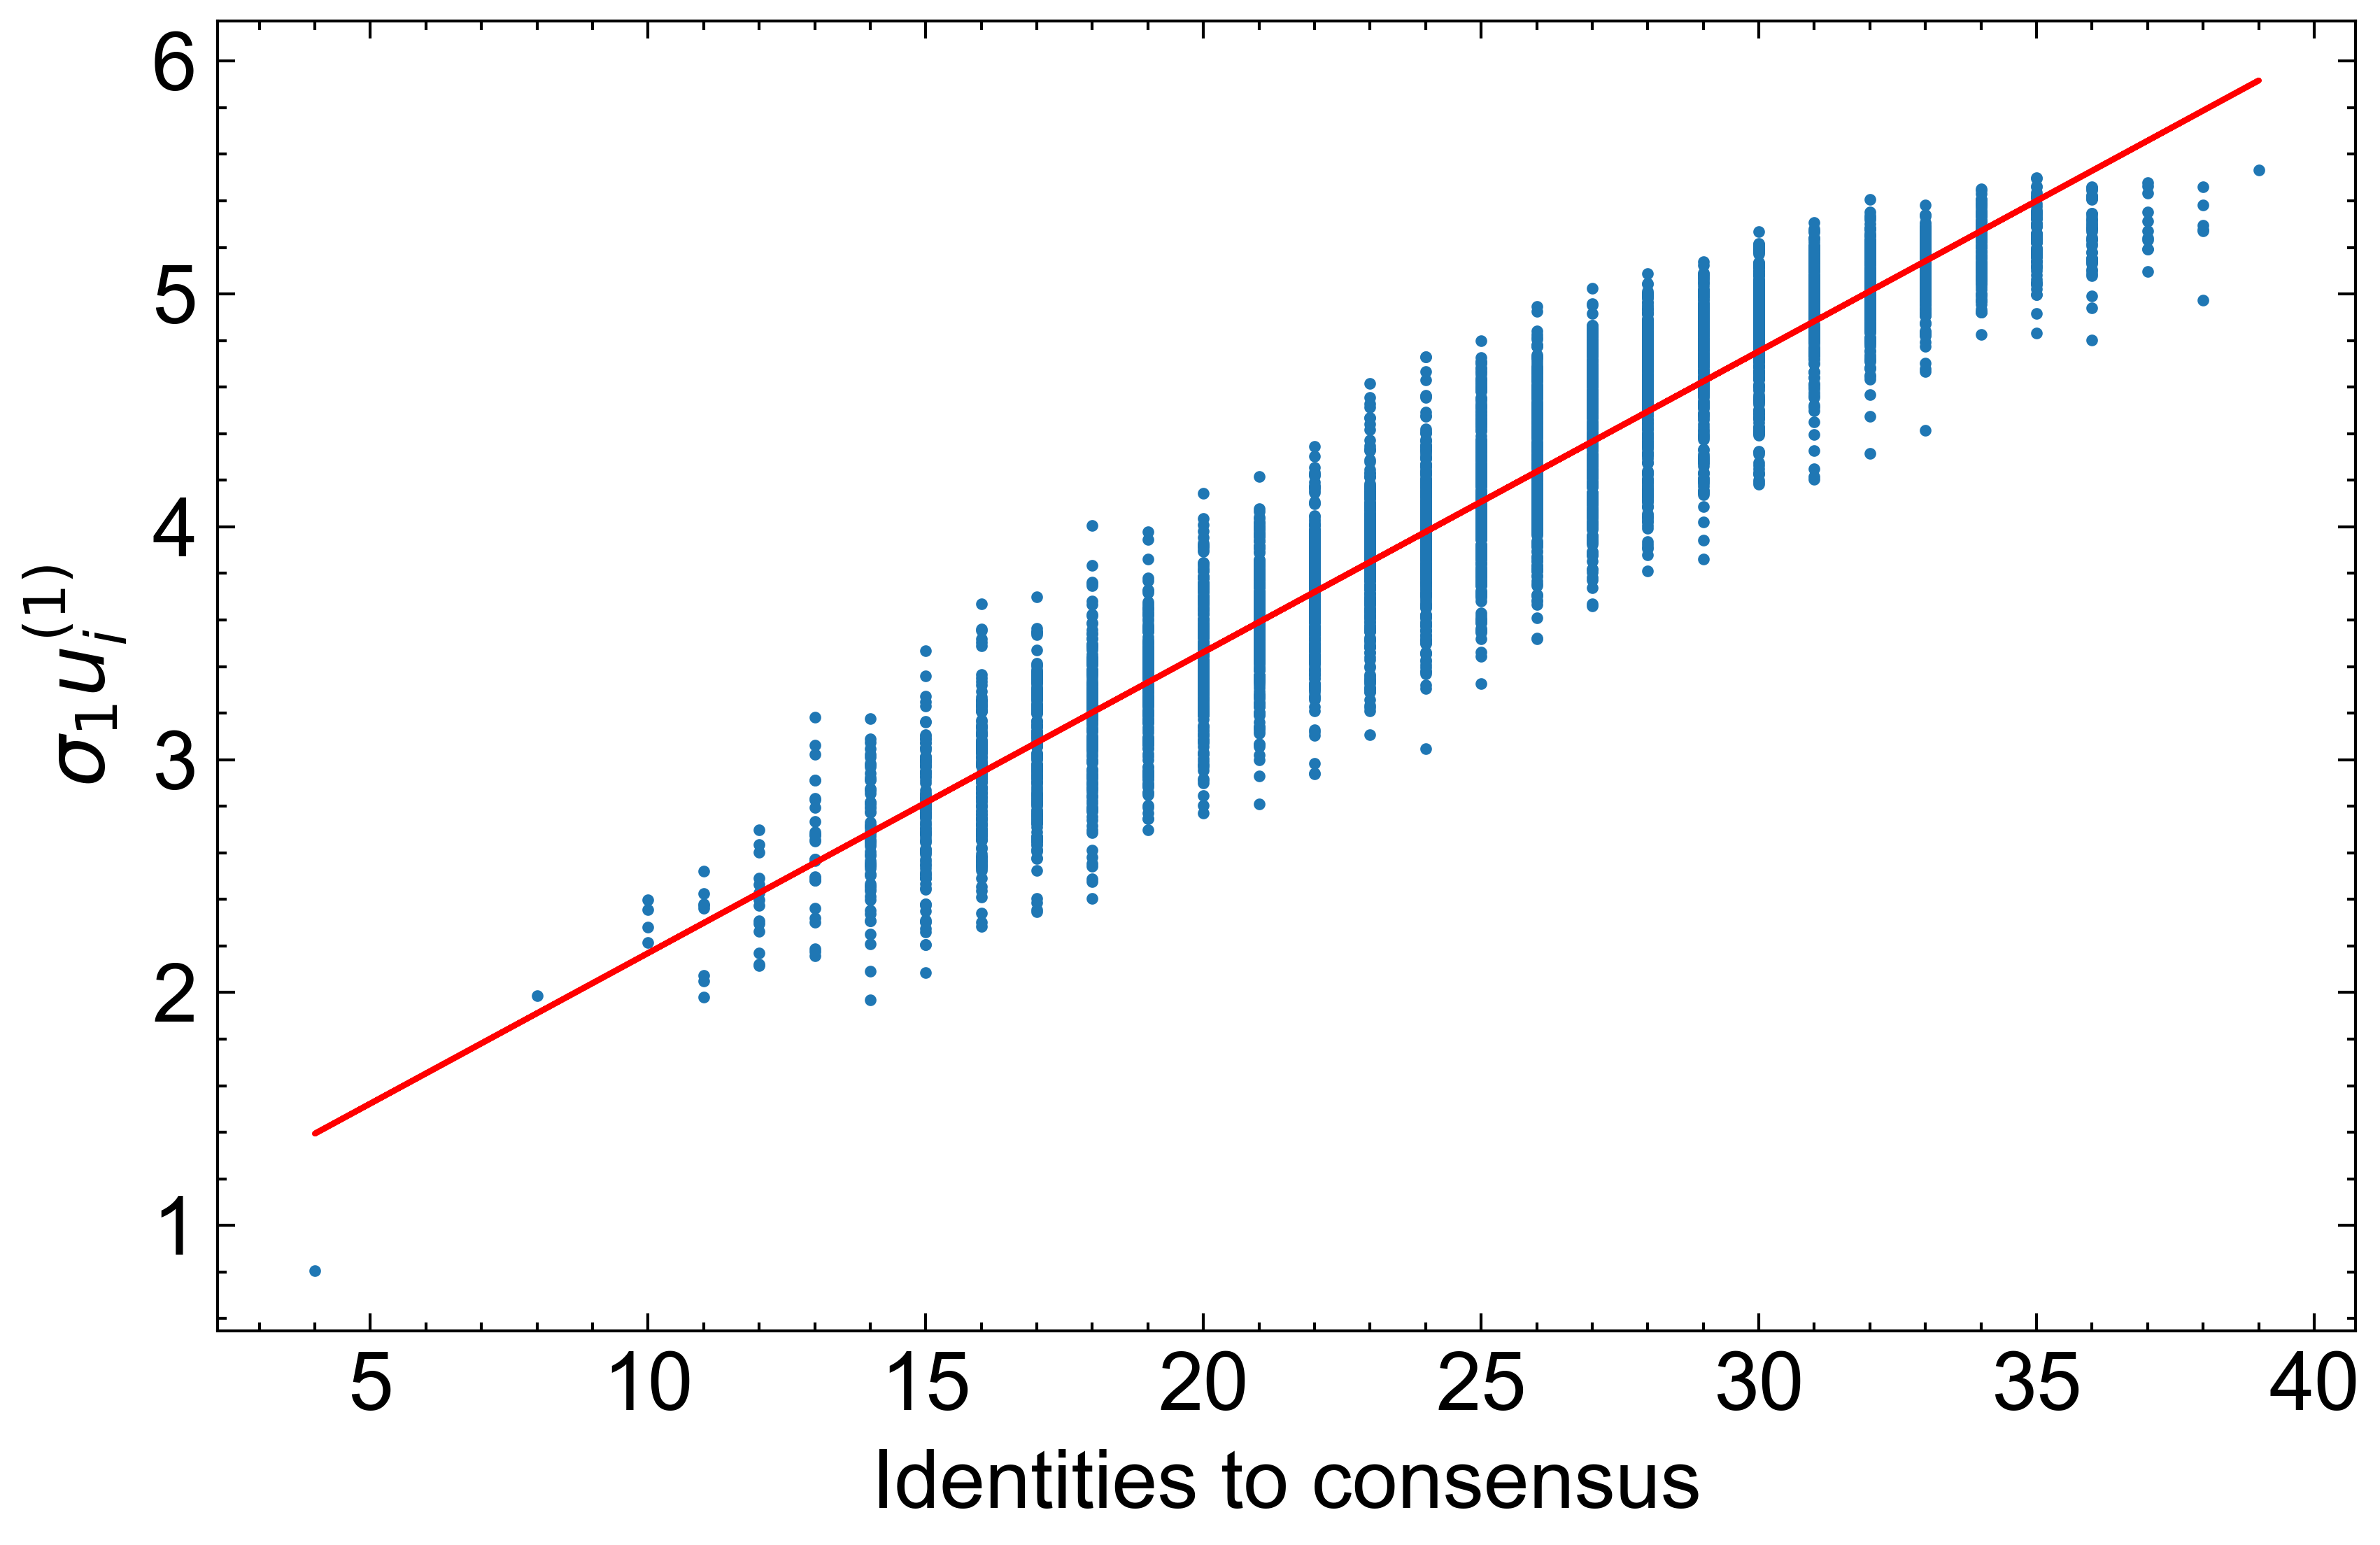

In [28]:
m, b = np.polyfit(idents_to_cons, S[0]*U[:, 0], 1)
pcc = sp.stats.pearsonr(idents_to_cons, S[0]*U[:, 0])
print(f'The correlation coefficient is {pcc}.')

fig5 = plt.figure(dpi=600)
plt.plot(idents_to_cons, S[0]*U[:,0], 'o', markersize = 1)
plt.plot(idents_to_cons, m*idents_to_cons + b, 'r')
plt.xlabel('Identities to consensus')
plt.ylabel(f'$\sigma_1 u_i^{{(1)}}$')

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_sigmaU_1_idents_cons.pdf')

## Plotting the Conensus Sequences in SVD space
MSA sequences are colored by their k-means cluster. The Pink star indicates the consensus sequence of the entire MSA. Colored squares show consensus sequences of each cluster

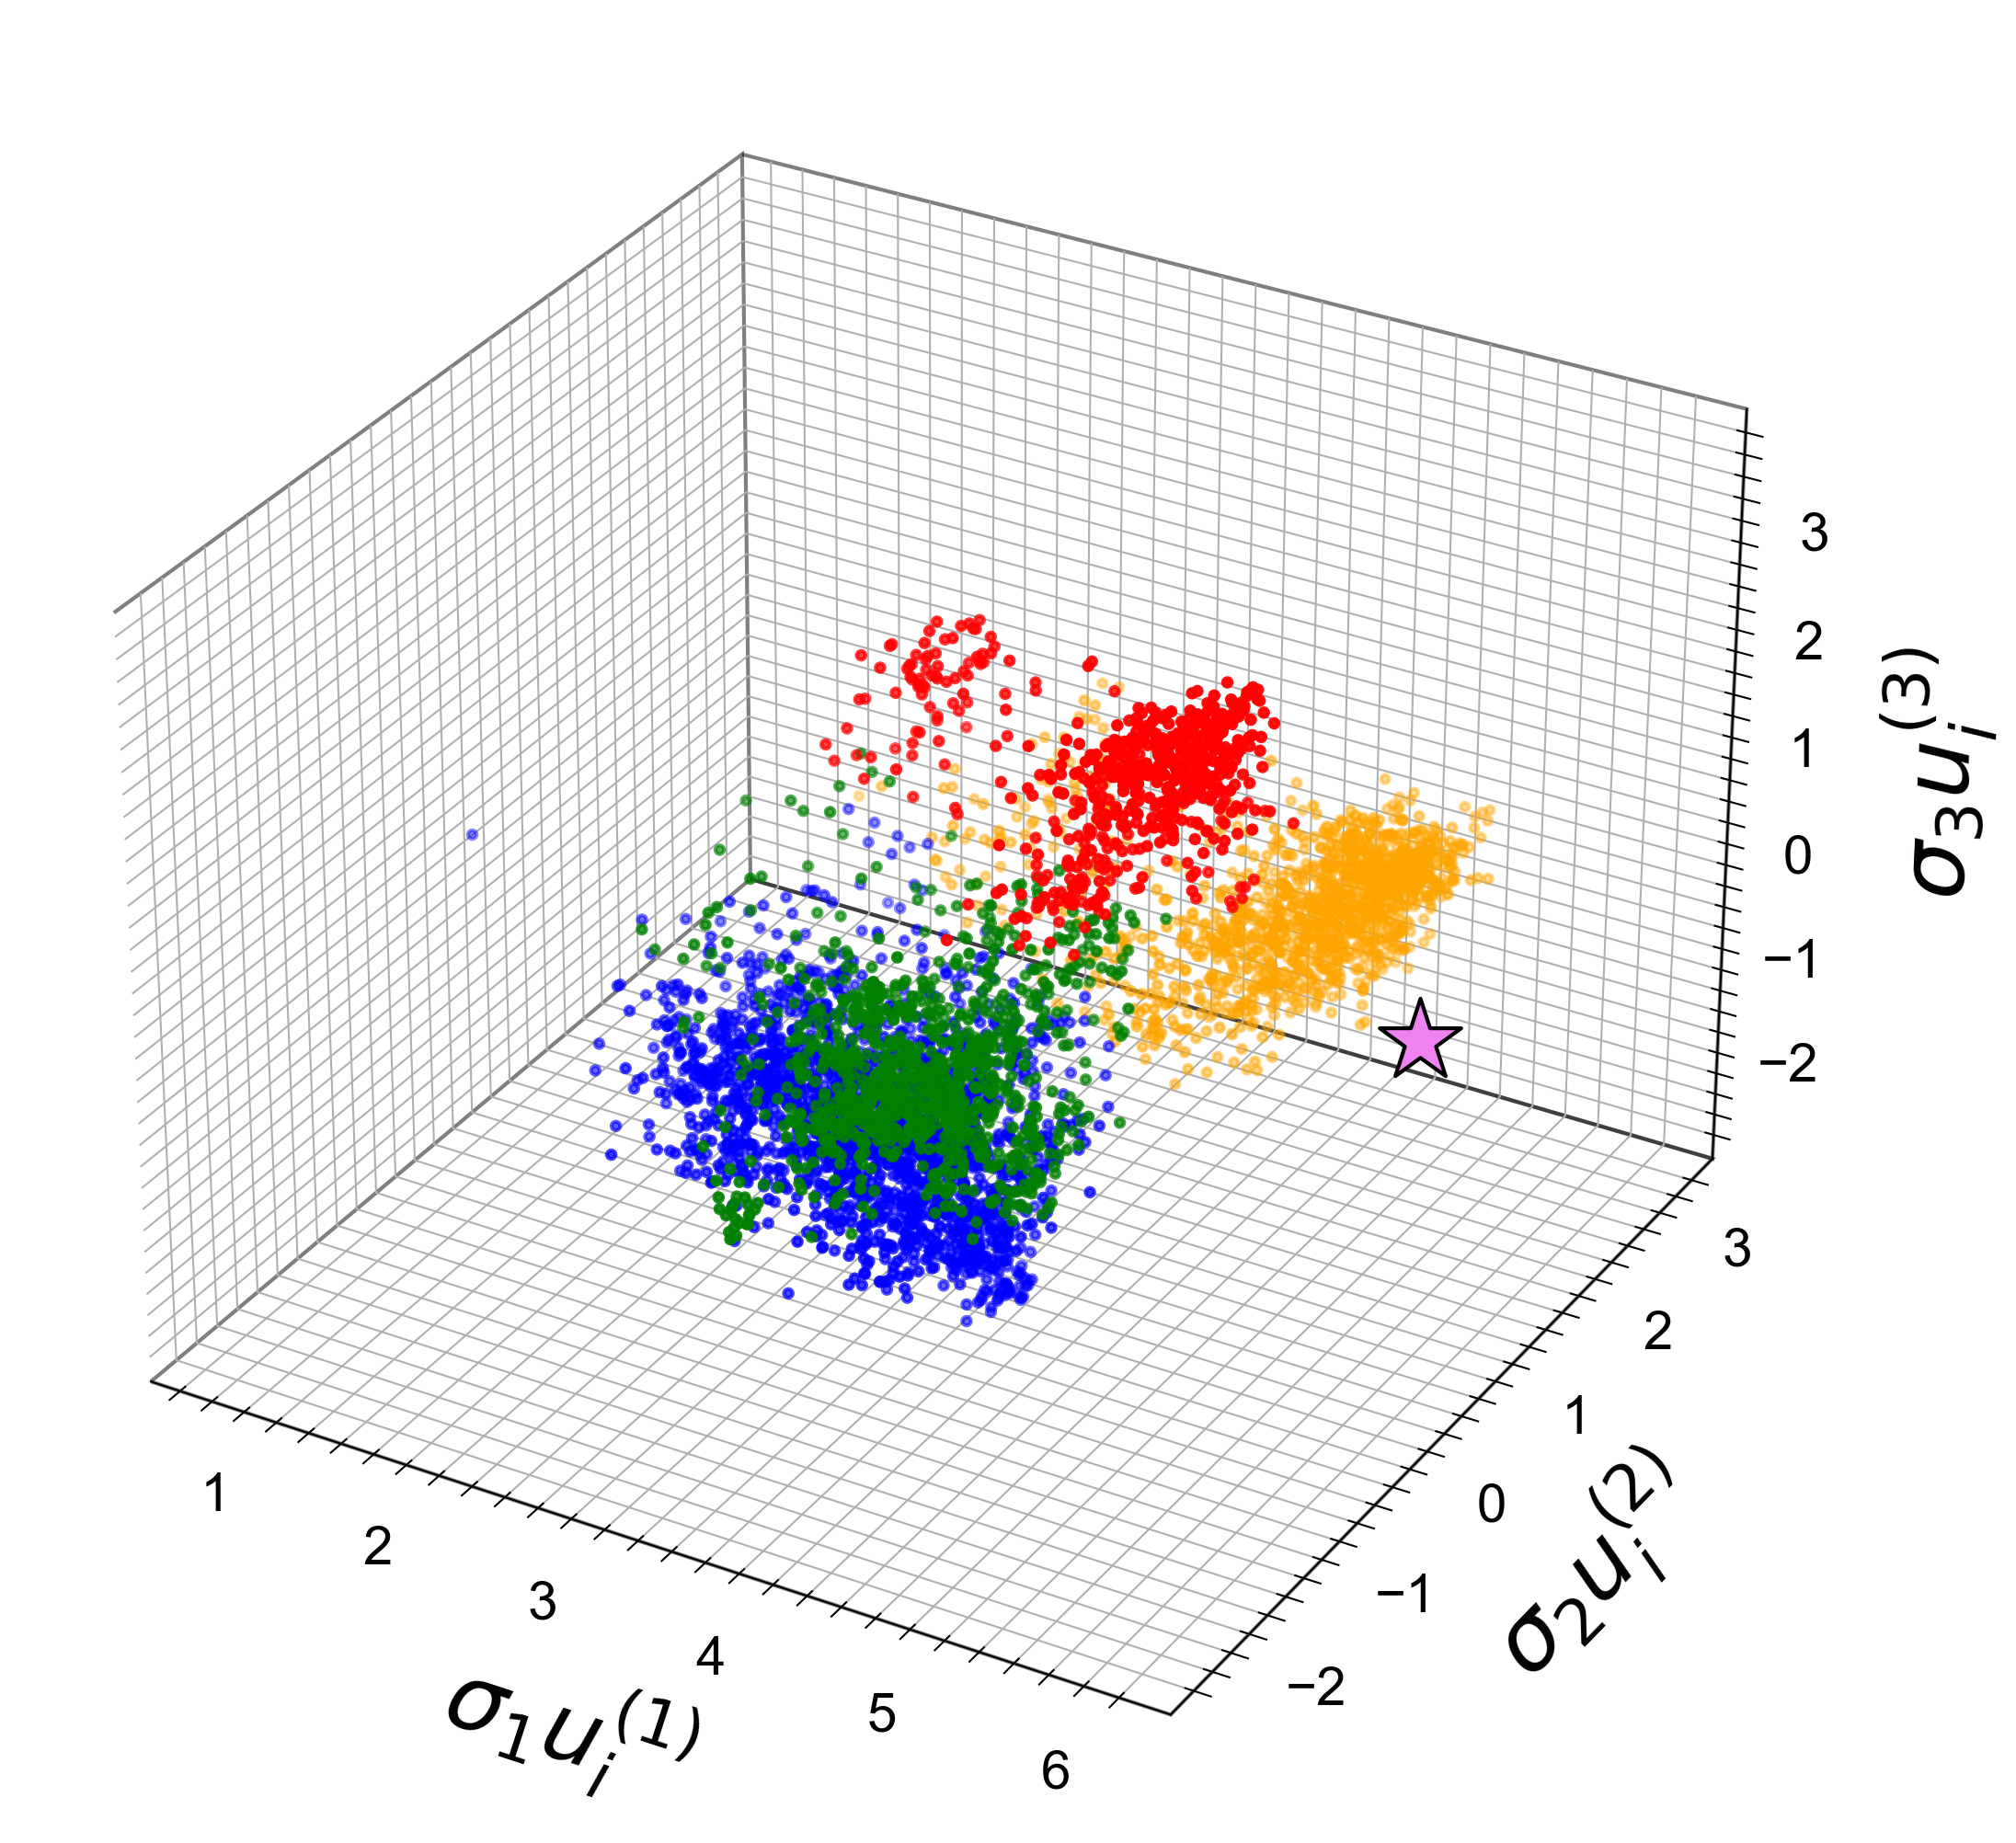

In [29]:
mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}

fig = plt.figure(1, figsize = (8, 7), dpi=300)
ax = fig.add_subplot(projection='3d')

ax.set_xlabel(f"\n$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=24)
ax.set_ylabel(f"\n$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=24)
ax.set_zlabel(f"\n$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=24)

ax.scatter(SU_df[0], SU_df[1], SU_df[2], c = cluster_color, s = 5)

ax.scatter(cons_all_sigmau_coords[0], cons_all_sigmau_coords[1], cons_all_sigmau_coords[2],
               c = 'violet', s = 500, marker='*', edgecolors='k')

# Uncomment block below if you want to plot consensus for each cluster
'''  
for i in range(len(cons_seqs_clusters)):
    ax.scatter(cons_clusters_sigmau_coords[i,0], 
               cons_clusters_sigmau_coords[i,1], 
               cons_clusters_sigmau_coords[i,2],
                c = colors[i], s = 100, marker='s', edgecolors='k')
'''

ax.view_init(30,300)

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_sigmaU_3dplot_cluster_cons.pdf')

MOVIES = 0
# Create movie of the 3D plot
if MOVIES == 1:
    
    imagedata = []
    
    for ii in range(0,360,1):
        # create temporary frame for movie
        ax.view_init(30, azim=ii)
        plt.savefig('movie%d.png' % ii)
        
        # save temporary frame for movie
        data = imageio.imread('movie{}.png'.format(ii))
        data = cv2.resize(data, (960, 960))
        imagedata.append(data)
        
        # remove temporary frame from directory
        os.remove('movie{}.png'.format(ii))

    imageio.mimwrite(f'figures/{PROTEIN_NAME}_sigmaU_3dplot_cluster_cons.mp4', imagedata, format= '.mp4', fps = 20)

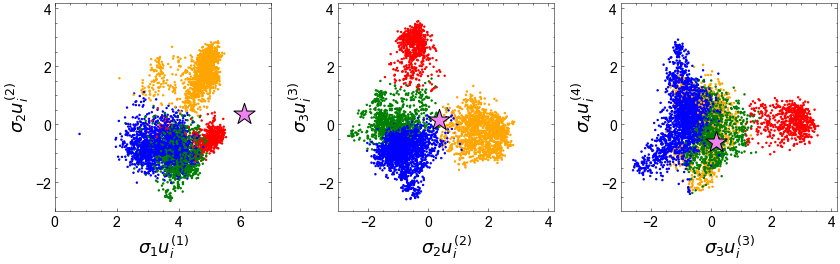

In [30]:
mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 32}

fig = plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.xlim(0, 7)
plt.ylim(-3, 4.2)
plt.scatter(S[0]*U[:,0], S[1]*U[:,1], s = 2, c = cluster_color)
plt.scatter(cons_all_sigmau_coords[0], cons_all_sigmau_coords[1],
            c = 'violet', s = 500, marker='*', edgecolors='k')
plt.xlabel(f'$\sigma_{1} u_i^{{({1})}}$', fontsize=18)
plt.ylabel(f'$\sigma_{2} u_i^{{({2})}}$', fontsize=18)

plt.subplot(1, 3, 2)
plt.xlim(-3, 4.2)
plt.ylim(-3, 4.2)
plt.scatter(S[1]*U[:,1], S[2]*U[:,2], s = 2, c = cluster_color)
plt.scatter(cons_all_sigmau_coords[1], cons_all_sigmau_coords[2],
            c = 'violet', s = 500, marker='*', edgecolors='k')
plt.xlabel(f'$\sigma_{2} u_i^{{({2})}}$', fontsize=18)
plt.ylabel(f'$\sigma_{3} u_i^{{({3})}}$', fontsize=18)

plt.subplot(1, 3, 3)
plt.xlim(-3, 4.2)
plt.ylim(-3, 4.2)
plt.scatter(S[2]*U[:,2], S[3]*U[:,3], s = 2, c = cluster_color)
plt.scatter(cons_all_sigmau_coords[2], cons_all_sigmau_coords[3],
            c = 'violet', s = 500, marker='*', edgecolors='k')
plt.xlabel(f'$\sigma_{3} u_i^{{({3})}}$', fontsize=18)
plt.ylabel(f'$\sigma_{4} u_i^{{({4})}}$', fontsize=18)

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_sigmaU_2dplots_cluster_cons.pdf')

## Plot residues in SVD space, and color residues that are enrichied in a cluster according to that cluster's color.

The *F_cluster_dict* dictionary below separates the F matrix into an F-matrix for each cluster (e.g., *F_cluster_1*). There is also a residue count for each cluster (e.g., *F_cluster_1_sum*) and a fraction (e.g., *F_cluster_1_fraction*), where the residue count is divided by the number of sequences in each cluster.
In addition, this dictionary contains the same information for sequences *not* in each cluster.

In [31]:
F_cluster_dict = {}

for cluster in range(CLUSTERS):
    F_cluster_dict[f'F_cluster_{cluster}'] = np.array([])
    F_cluster_dict[f'F_cluster_{cluster}_sum'] = np.zeros(len(F[0]))
    F_cluster_dict[f'F_not_cluster_{cluster}'] = np.array([])
    F_cluster_dict[f'F_not_cluster_{cluster}_sum'] = np.zeros(len(F[0]))
    
    is_cluster = np.where(cluster_ID == cluster)[0]
    is_not_cluster = np.where(cluster_ID != cluster)[0]
    
    F_cluster_dict[f'F_cluster_{cluster}'] = F[is_cluster]
    F_cluster_dict[f'F_cluster_{cluster}_sum'] = sum(F[is_cluster])
    
    F_cluster_dict[f'F_not_cluster_{cluster}'] = F[is_not_cluster]
    F_cluster_dict[f'F_not_cluster_{cluster}_sum'] = sum(F[is_not_cluster])

    # save frequency of residues in sequences
    F_cluster_dict[f'F_cluster_{cluster}_fraction'] = \
        F_cluster_dict[f'F_cluster_{cluster}_sum']/len(F_cluster_dict[f'F_cluster_{cluster}'])
    
    F_cluster_dict[f'F_not_cluster_{cluster}_fraction'] = \
        F_cluster_dict[f'F_not_cluster_{cluster}_sum']/len(F_cluster_dict[f'F_not_cluster_{cluster}'])

## Next make plots showing the fraction of each residue (position/residue) for each cluster

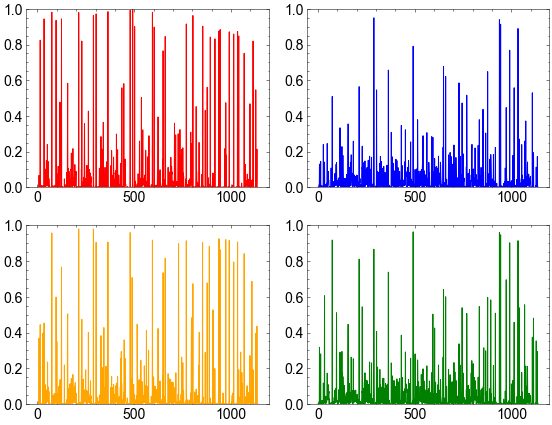

In [32]:
fig6 = plt.figure(figsize=(8,12))

for c in range(CLUSTERS):
    plt.subplot(4, 2, c+1)
    plt.plot(F_cluster_dict[f'F_cluster_{c}_fraction'], c = colors[c])
    plt.ylim(0, 1)

plt.tight_layout()

There are clear variations from one cluster to the next in the plots above, but it is hard to see through the variation due to overall sequence conservation that is the same for all clusters (i.e., a general consensus).  Variations between clusters would be easier to identify as differences, that is, fraction in one cluster minus something out of cluster.  Here we will take the difference between one cluster and everyting outside the cluster. 

## Generate differences of in-cluster vs. out-of-cluster residue frequencies

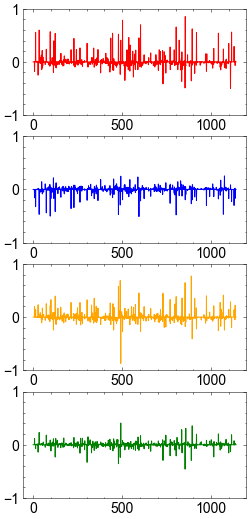

In [33]:
minus_not = {}

fig7 = plt.figure(figsize=(4,9))

for c in range(CLUSTERS):
    minus_not[f'{c}_minus_not_{c}'] = F_cluster_dict[f'F_cluster_{c}_fraction'] - F_cluster_dict[f'F_not_cluster_{c}_fraction']
    
    plt.subplot(4, 1, c+1)
    plt.plot(minus_not[f'{c}_minus_not_{c}'], colors[c])
    plt.ylim((-1, 1))

## Create lists of residues where in-cluster frequency exceeds out-of-cluster frequency by a specified threshold

In [34]:
threshold = 0.4

enriched = {}
depleted = {}
not_enriched = []

for minus, c in zip(minus_not, range(CLUSTERS)):
    enriched[f'{c}_enriched'] = np.where(minus_not[minus] > threshold)[0]
    depleted[f'{c}_depleted'] = np.where(minus_not[minus] < threshold)[0]

all_depleted = [v for k,v in depleted.items()]
not_enriched = all_depleted[all_depleted == CLUSTERS]

for c in range(CLUSTERS):
    num = len(enriched[f'{c}_enriched'])
    print(f'Number of residues enriched in cluster {colors[c]} is {num}.')

print(f'Number of residues not enriched in any cluster is {len(not_enriched)}.')

Number of residues enriched in cluster red is 20.
Number of residues enriched in cluster blue is 0.
Number of residues enriched in cluster orange is 7.
Number of residues enriched in cluster green is 1.
Number of residues not enriched in any cluster is 1120.


In [36]:
# The below code will output the identities of the specific residues that are enriched.
res_enriched = {}

for c in range(CLUSTERS):
    res_enriched[f'{c}_enriched'] = []
    for e in enriched[f'{c}_enriched']:
        res_idx = e % 20
        if res_idx != 0:
            res_ohe = '0'*(res_idx) + '1' + '0'*(20-res_idx-1)
        else:
            res_ohe = '1' + '0'*19
        res_identity = list(encoder.keys())[list(encoder.values()).index(res_ohe)]
        res_position = (e - res_idx) / 20 + 1
        res_enriched[f'{c}_enriched'].append(res_identity + str(int(res_position)))

for c in range(CLUSTERS):
    residues = res_enriched[f'{c}_enriched']
    if len(residues) != 0:
        print(f'The residues enriched in the {colors[c]} cluster are {", ".join(residues)}.')

The residues enriched in the red cluster are R1, R2, T5, F7, L12, T22, H23, Y24, P25, D26, V27, R30, E31, E41, A42, R43, Q45, V46, A53, R56.
The residues enriched in the orange cluster are Y24, L25, R30, L37, Q43, K45, K54.
The residues enriched in the green cluster are P25.


## Collect $v_i^{(k)}$ values for enriched residues in each cluster.

In [37]:
enriched_V = {}

V_len = len(V.transpose())

for c in range(CLUSTERS):
    enriched_V[f'{c}_enriched_V'] = np.zeros((len(enriched[f'{c}_enriched']), V_len))
    enriched_V[f'{c}_enriched_V'] = V[enriched[f'{c}_enriched'], :]

not_enriched_V = np.zeros((len(not_enriched), len(V.transpose())))
not_enriched_V = V[not_enriched, :]

### Plot $v_i^{(k)}$ values for enriched and not-enriched residues.

#### 3D plot of cluster-enriched $v_i^{(k)}$ values along the first three singular axes

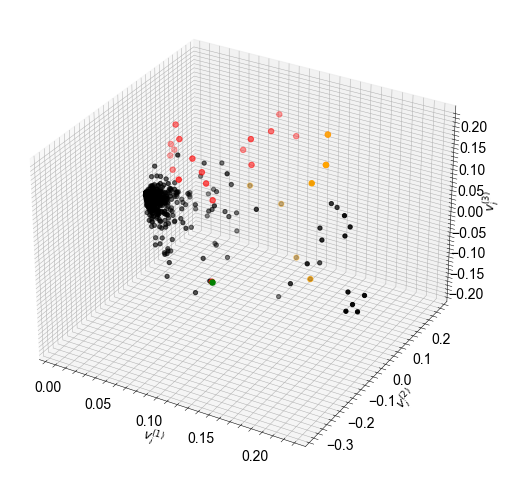

In [38]:
fig = plt.figure(1, figsize = (8, 7))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel(f"$v_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$v_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$v_i^{{({3})}}$", fontsize=12)


ax.scatter(not_enriched_V[:, 0], not_enriched_V[:, 1], not_enriched_V[:, 2], c = 'k', s = 18)

for c in range(CLUSTERS):
    ax.scatter(enriched_V[f'{c}_enriched_V'][:, 0], 
               enriched_V[f'{c}_enriched_V'][:, 1], 
               enriched_V[f'{c}_enriched_V'][:, 2], c = colors[c], s = 30)

ax.view_init(30,300)
plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_V_enriched_3dplot.pdf')

# Create movie of the 3D plot
if MOVIES == 1:
    imagedata = []
    for ii in range(0,360,1):
        # create temporary frame for movie
        ax.view_init(30, azim=ii)
        plt.savefig('movie%d.png' % ii)
        
        # save temporary frame for movie
        data = imageio.imread('movie{}.png'.format(ii))
        data = cv2.resize(data, (960, 960))
        imagedata.append(data)
        
        # remove temporary frame from directory
        os.remove('movie{}.png'.format(ii))

    imageio.mimwrite(f'figures/{PROTEIN_NAME}_V_enriched_3dplot.mp4', imagedata, format= '.mp4', fps = 20)

#### 2D plot of cluster-enriched $v_i^{(k)}$ values along the first four singular axes

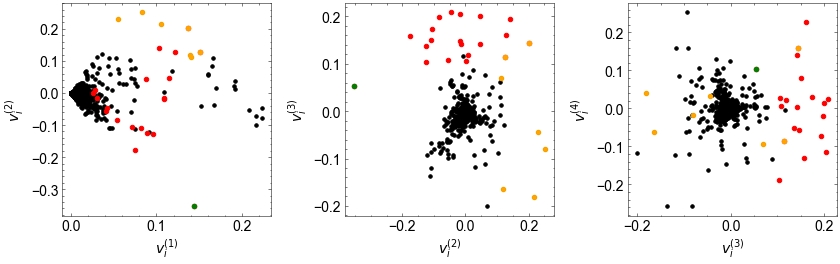

In [39]:
fig = plt.figure(figsize=(12,4))

for i in range(3):
    plt.subplot(1, 3, i+1)

    plt.scatter(not_enriched_V[:, i], not_enriched_V[:, i+1], c = 'k', s = 12)
    for c in range(CLUSTERS):
        plt.scatter(enriched_V[f'{c}_enriched_V'][:, i], 
                   enriched_V[f'{c}_enriched_V'][:, i+1], c = colors[c], s = 20)
    
    plt.xlabel(f"$v_i^{{({i+1})}}$")
    plt.ylabel(f"$v_i^{{({i+2})}}$")

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_V_enriched_2dplots.pdf')

### Plot $v_i^{(1)}$ versus frequency of each residue--strong correlation.

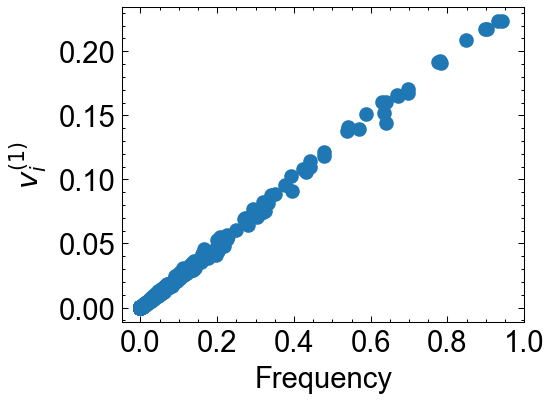

In [40]:
# Create an array that gives the frequency of each of the 20 l residues
F_freq = np.zeros(len(F.transpose()))
for resi in range(len(F.transpose())):
    F_freq[resi] = np.sum(F[:, resi])/len(F)

fig = plt.figure(figsize=(4,3), dpi=150)
plt.plot(F_freq, V[:, 0], 'o')
plt.xlabel('Frequency')
plt.ylabel('$v_i^{(1)}$')
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_freq_vs_v(1).pdf')

### Show that residues enriched in clusters point in the same direction in $v_i^{(2)}$, $v_i^{(3)}$ space as $\sigma_2 u_i^{(2)}$, $\sigma_2 u_i^{(3)}$.

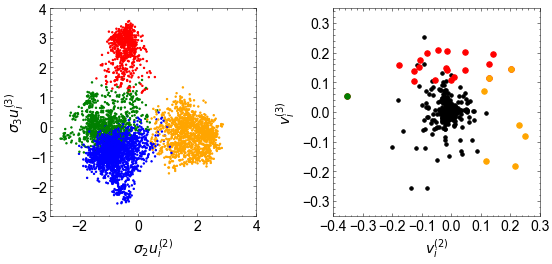

In [41]:
fig = plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
plt.xlim(-3, 4)
plt.ylim(-3, 4)
plt.scatter(S[1]*U[:,1], S[2]*U[:,2], s = 2, c = cluster_color)
plt.xlabel(f'$\sigma_{2} u_i^{{({2})}}$')
plt.ylabel(f'$\sigma_{3} u_i^{{({3})}}$')

plt.subplot(1, 2, 2)
plt.xlim(-0.4, 0.3)
plt.ylim(-0.35, 0.35)

plt.scatter(not_enriched_V[:, i], not_enriched_V[:, i+1], c = 'k', s = 12)
for c in range(CLUSTERS):
    plt.scatter(enriched_V[f'{c}_enriched_V'][:, 1], 
               enriched_V[f'{c}_enriched_V'][:, 2], c = colors[c], s = 30)
    
plt.xticks([-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3])
plt.yticks([-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3])
plt.xlabel(f'$v_i^{{({2})}}$')
plt.ylabel(f'$v_i^{{({3})}}$')

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_su23_v23_2dplots.pdf')


## Projection of Drosophila HD sequences from Stormo/Wolf specificity paper into SVD space

In [42]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

from Bio.SubsMat import MatrixInfo as matlist
matrix = matlist.blosum62

/Users/ginaelnesr/anaconda3/lib/python3.8/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


Import Stormo sequences with gene name and class into a pandas df.

In [43]:
stormo_df = pd.read_csv('Stormo_HD_seqs.csv', header=0)

Function that aligns stormo seqeuence to consensus.  Uses blosum62 substitution matrix and a fairly aggressive gap penalty

In [44]:
def align_to_consensus(cons_seq, test_seq):
    alignment = pairwise2.align.globalds(cons_seq, test_seq, matrix, -5, -1)
    aligned_test_seq = ''
    for posn in range(len(alignment[0][1])):
        if alignment[0][0][posn] != '-':
            aligned_test_seq += (alignment[0][1][posn])
    
    return aligned_test_seq

In [45]:
aligned_seq_list = []

for j in range(len(stormo_df)):
    aligned_seq = align_to_consensus(cons_seq_all, stormo_df['sequence'][j])
    aligned_seq_list.append(aligned_seq)
    
stormo_df['aligned sequence'] = aligned_seq_list

In [46]:
ohe_seq_list = []
s1u1_list = []
s2u2_list = []
s3u3_list = []
s4u4_list = []

for seq in stormo_df['aligned sequence']:
    ohe_seq = ohe(seq)
    ohe_seq_list.append(ohe_seq)
    s1u1 = np.dot(ohe_seq, V[:,0])
    s1u1_list.append(s1u1)
    s2u2 = np.dot(ohe_seq, V[:,1])
    s2u2_list.append(s2u2)
    s3u3 = np.dot(ohe_seq, V[:,2])
    s3u3_list.append(s3u3)
    s4u4 = np.dot(ohe_seq, V[:,3])
    s4u4_list.append(s4u4)

stormo_df['ohe seq'] = ohe_seq_list
stormo_df['s1u1'] = s1u1_list
stormo_df['s2u2'] = s2u2_list
stormo_df['s3u3'] = s3u3_list
stormo_df['s4u4'] = s4u4_list

In [47]:
en_df = stormo_df[stormo_df['class'] == 'en'].reset_index(drop=True)
antp_df = stormo_df[stormo_df['class'] == 'antp'].reset_index(drop=True)
abdb_df = stormo_df[stormo_df['class'] == 'abdb'].reset_index(drop=True)
nk1_df = stormo_df[stormo_df['class'] == 'nk1'].reset_index(drop=True)
nk2_df = stormo_df[stormo_df['class'] == 'nk2'].reset_index(drop=True)
bar_df = stormo_df[stormo_df['class'] == 'bar'].reset_index(drop=True)
bcd_df = stormo_df[stormo_df['class'] == 'bcd'].reset_index(drop=True)
tgif_df = stormo_df[stormo_df['class'] == 'tgif'].reset_index(drop=True)
iroquois_df = stormo_df[stormo_df['class'] == 'iroquois'].reset_index(drop=True)
six_df = stormo_df[stormo_df['class'] == 'six'].reset_index(drop=True)
ladybird_df = stormo_df[stormo_df['class'] == 'ladybird'].reset_index(drop=True)

## Plotting the engrailed sequences in SVD space
MSA sequences are colored by their k-means cluster. The Pink star indicates the consensus sequence of the entire MSA. Colored squares show consensus sequences of each cluster

For readability purposes, we make a function that saves the plot from the sequence alignment, and takes in the dataframe of the particular class of Homeodomain we want projected into SVD space

In [48]:
def plot_MSA(df):
    fig = plt.figure(figsize=(12,4))

    plt.subplot(1, 3, 1)
    plt.xlim(0, 7)
    plt.ylim(-3, 4)
    plt.scatter(S[0]*U[:,0], S[1]*U[:,1], s = 2, c = cluster_color)
    plt.scatter(cons_all_sigmau_coords[0], cons_all_sigmau_coords[1],
                c = 'violet', s = 500, marker='*', edgecolors='k')
    plt.scatter(df['s1u1'], df['s2u2'], c = 'black')
    plt.xlabel(f'$\sigma_{1} u_i^{{({1})}}$')
    plt.ylabel(f'$\sigma_{2} u_i^{{({2})}}$')

    plt.subplot(1, 3, 2)
    plt.xlim(-3, 4)
    plt.ylim(-3, 4)
    plt.scatter(S[1]*U[:,1], S[2]*U[:,2], s = 2, c = cluster_color)
    plt.scatter(cons_all_sigmau_coords[1], cons_all_sigmau_coords[2],
                c = 'violet', s = 500, marker='*', edgecolors='k')
    plt.scatter(df['s2u2'], df['s3u3'], c = 'black')
    plt.xlabel(f'$\sigma_{2} u_i^{{({2})}}$')
    plt.ylabel(f'$\sigma_{3} u_i^{{({3})}}$')

    plt.subplot(1, 3, 3)
    plt.xlim(-3, 4)
    plt.ylim(-3, 4)
    plt.scatter(S[2]*U[:,2], S[3]*U[:,3], s = 2, c = cluster_color)
    plt.scatter(cons_all_sigmau_coords[2], cons_all_sigmau_coords[3],
                c = 'violet', s = 500, marker='*', edgecolors='k')
    plt.scatter(df['s3u3'], df['s4u4'], c = 'black')
    plt.xlabel(f'$\sigma_{3} u_i^{{({3})}}$')
    plt.ylabel(f'$\sigma_{4} u_i^{{({4})}}$')

    plt.tight_layout()

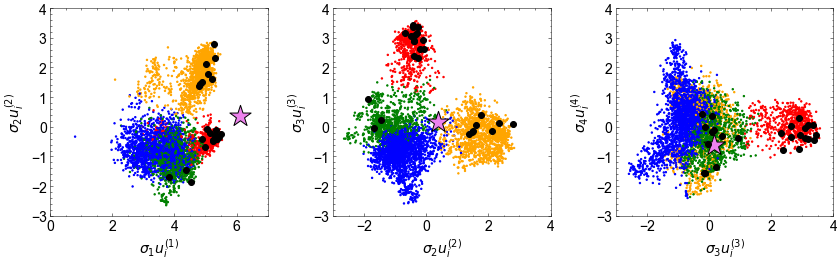

In [49]:
# Engrailed
plot_MSA(en_df)

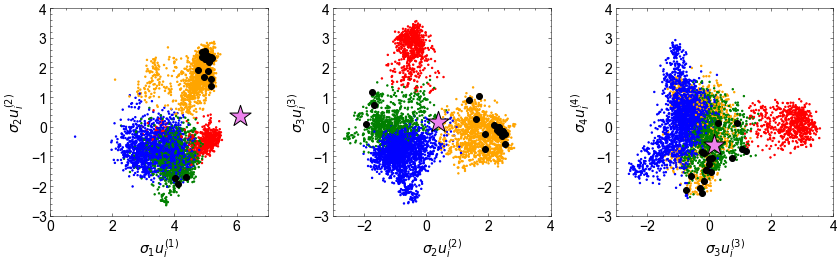

In [50]:
# Antennapedia
plot_MSA(antp_df)

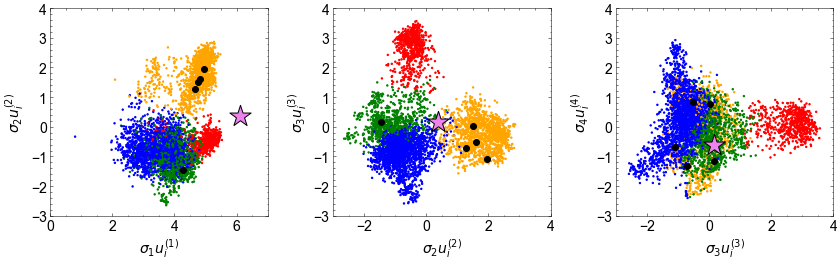

In [51]:
# abdb
plot_MSA(abdb_df)

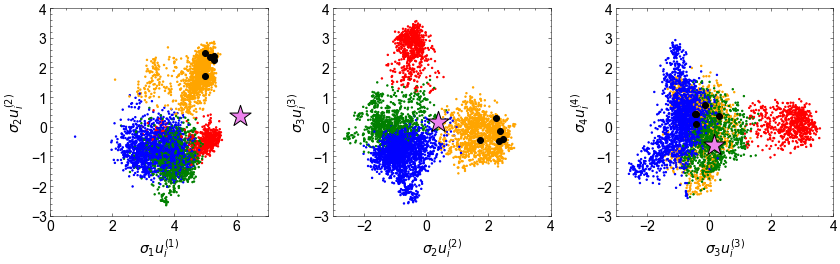

In [52]:
#NK1
plot_MSA(nk1_df)

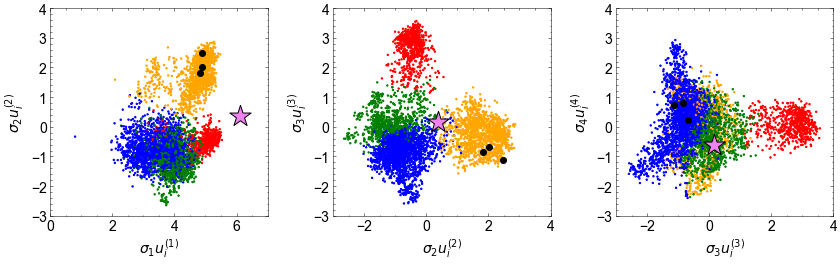

In [53]:
#NK2
plot_MSA(nk2_df)

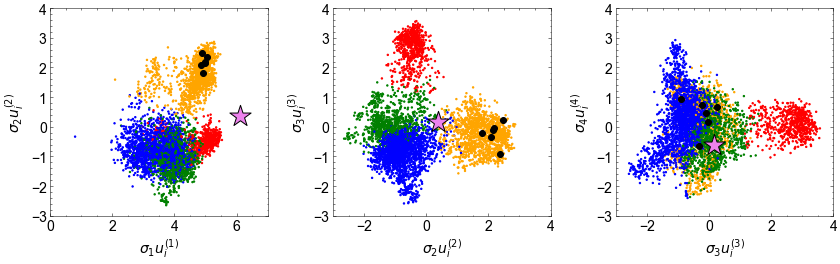

In [54]:
#bar
plot_MSA(bar_df)

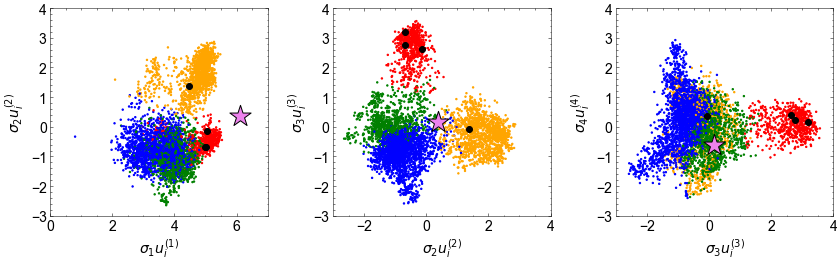

In [55]:
#BCD
plot_MSA(bcd_df)

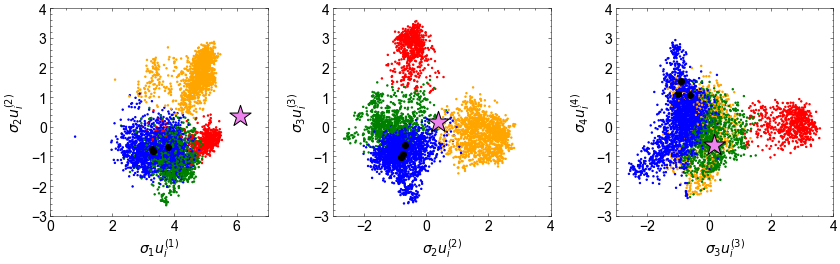

In [56]:
#tgif
plot_MSA(tgif_df)

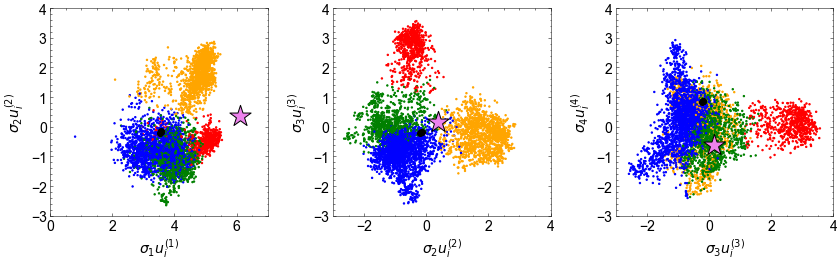

In [57]:
#Iroquois
plot_MSA(iroquois_df)

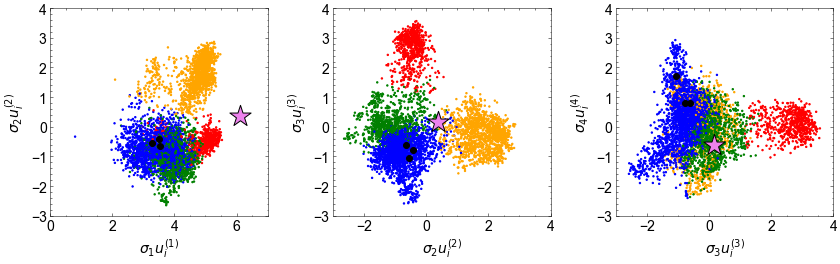

In [58]:
#six
plot_MSA(six_df)

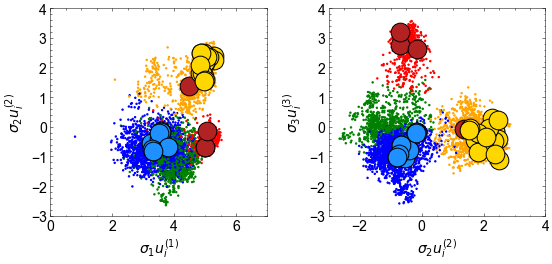

In [59]:
mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}

fig = plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
plt.xlim(0, 7)
plt.ylim(-3, 4)
plt.scatter(S[0]*U[:,0], S[1]*U[:,1], s = 2, c = cluster_color)
plt.scatter(six_df['s1u1'], six_df['s2u2'], s=350, c='dodgerblue', edgecolors='black')
plt.scatter(iroquois_df['s1u1'], iroquois_df['s2u2'], s=350, c='dodgerblue', edgecolors='black')
plt.scatter(tgif_df['s1u1'], tgif_df['s2u2'], s=350, c='dodgerblue', edgecolors='black')
plt.scatter(bcd_df['s1u1'], bcd_df['s2u2'], s=350, c='firebrick', edgecolors='black')
plt.scatter(nk1_df['s1u1'], nk1_df['s2u2'], s=350, c='gold', edgecolors='black')
plt.scatter(nk2_df['s1u1'], nk2_df['s2u2'], s=350, c='gold', edgecolors='black')
plt.scatter(bar_df['s1u1'], bar_df['s2u2'], s=350, c='gold', edgecolors='black')
plt.scatter(ladybird_df['s1u1'], ladybird_df['s2u2'], s=350, c='gold', edgecolors='black')
plt.xlabel(f'$\sigma_{1} u_i^{{({1})}}$')
plt.ylabel(f'$\sigma_{2} u_i^{{({2})}}$')

plt.subplot(1, 2, 2)
plt.xlim(-3, 4)
plt.ylim(-3, 4)
plt.scatter(S[1]*U[:,1], S[2]*U[:,2], s = 2, c = cluster_color)
plt.scatter(six_df['s2u2'], six_df['s3u3'], s=350, c='dodgerblue', edgecolors='black')
plt.scatter(iroquois_df['s2u2'], iroquois_df['s3u3'], s=350, c='dodgerblue', edgecolors='black')
plt.scatter(tgif_df['s2u2'], tgif_df['s3u3'], s=350, c='dodgerblue', edgecolors='black')
plt.scatter(bcd_df['s2u2'], bcd_df['s3u3'], s=350, c='firebrick', edgecolors='black')
plt.scatter(nk1_df['s2u2'], nk1_df['s3u3'], s=350, c='gold', edgecolors='black')
plt.scatter(nk2_df['s2u2'], nk2_df['s3u3'], s=350, c='gold', edgecolors='black')
plt.scatter(bar_df['s2u2'], bar_df['s3u3'], s=350, c='gold', edgecolors='black')
plt.scatter(ladybird_df['s2u2'], ladybird_df['s3u3'], s=350, c='gold', edgecolors='black')
plt.xlabel(f'$\sigma_{2} u_i^{{({2})}}$')
plt.ylabel(f'$\sigma_{3} u_i^{{({3})}}$')

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_SigmaU_2_2dplots_cluster_stormo.pdf')

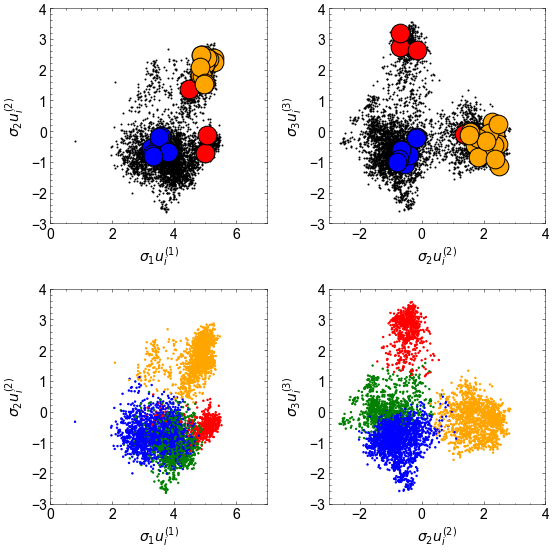

In [60]:
mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}

fig = plt.figure(figsize=(8,8))

plt.subplot(2, 2, 3)
plt.xlim(0, 7)
plt.ylim(-3, 4)
plt.scatter(S[0]*U[:,0], S[1]*U[:,1], s = 2, c = cluster_color)
plt.xlabel(f'$\sigma_{1} u_i^{{({1})}}$')
plt.ylabel(f'$\sigma_{2} u_i^{{({2})}}$')

plt.subplot(2, 2, 4)
plt.xlim(-3, 4)
plt.ylim(-3, 4)
plt.scatter(S[1]*U[:,1], S[2]*U[:,2], s = 2, c = cluster_color)
plt.xlabel(f'$\sigma_{2} u_i^{{({2})}}$')
plt.ylabel(f'$\sigma_{3} u_i^{{({3})}}$')

plt.subplot(2, 2, 1)
plt.xlim(0, 7)
plt.ylim(-3, 4)
plt.scatter(S[0]*U[:,0], S[1]*U[:,1], s = 1, c = 'black')
plt.scatter(six_df['s1u1'], six_df['s2u2'], s=350, c='blue', edgecolors='black', alpha=1)
plt.scatter(iroquois_df['s1u1'], iroquois_df['s2u2'], s=350, c='blue', edgecolors='black', alpha=1)
plt.scatter(tgif_df['s1u1'], tgif_df['s2u2'], s=350, c='blue', edgecolors='black', alpha=1)
plt.scatter(bcd_df['s1u1'], bcd_df['s2u2'], s=350, c='red', edgecolors='black', alpha=1)
plt.scatter(nk1_df['s1u1'], nk1_df['s2u2'], s=350, c='orange', edgecolors='black', alpha=1)
plt.scatter(nk2_df['s1u1'], nk2_df['s2u2'], s=350, c='orange', edgecolors='black', alpha=1)
plt.scatter(bar_df['s1u1'], bar_df['s2u2'], s=350, c='orange', edgecolors='black', alpha=1)
plt.scatter(ladybird_df['s1u1'], ladybird_df['s2u2'], s=350, c='orange', edgecolors='black', alpha=1)
plt.xlabel(f'$\sigma_{1} u_i^{{({1})}}$')
plt.ylabel(f'$\sigma_{2} u_i^{{({2})}}$')

plt.subplot(2, 2, 2)
plt.xlim(-3, 4)
plt.ylim(-3, 4)
plt.scatter(S[1]*U[:,1], S[2]*U[:,2], s = 1, c = 'black')
plt.scatter(six_df['s2u2'], six_df['s3u3'], s=350, c='blue', edgecolors='black', alpha=1)
plt.scatter(iroquois_df['s2u2'], iroquois_df['s3u3'], s=350, c='blue', edgecolors='black', alpha=1)
plt.scatter(tgif_df['s2u2'], tgif_df['s3u3'], s=350, c='blue', edgecolors='black', alpha=1)
plt.scatter(bcd_df['s2u2'], bcd_df['s3u3'], s=350, c='red', edgecolors='black', alpha=1)
plt.scatter(nk1_df['s2u2'], nk1_df['s3u3'], s=350, c='orange', edgecolors='black', alpha=1)
plt.scatter(nk2_df['s2u2'], nk2_df['s3u3'], s=350, c='orange', edgecolors='black', alpha=1)
plt.scatter(bar_df['s2u2'], bar_df['s3u3'], s=350, c='orange', edgecolors='black', alpha=1)
plt.scatter(ladybird_df['s2u2'], ladybird_df['s3u3'], s=350, c='orange', edgecolors='black', alpha=1)
plt.xlabel(f'$\sigma_{2} u_i^{{({2})}}$')
plt.ylabel(f'$\sigma_{3} u_i^{{({3})}}$')

plt.tight_layout()
plt.savefig(f'figures/{PROTEIN_NAME}_SigmaU_2_2dplots_cluster_stormo.pdf')